In [ ]:
# -*- coding: utf-8 -*-
"""
Created on 2023/06/24
Revised on 2023/06/24

@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
Network Engineering Department
"""
###########################################################################
# Seminar on Quantum Technologies for Communications and Computing: Networking and Systems
# Class
# Session 3 - Quantum Computing

from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>")
import os, sys, time
import numpy as np
import math, scipy
import tqdm
import matplotlib.pyplot as plt
#from google.colab import files # This line can be commented when running in local computer
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:
  import qiskit
  import qiskit_ibm_runtime
  import qiskit_aer
except:
  print("installing qiskit...")
  !pip install qiskit -U --quiet
  # Installs the latest version of the Qiskit Runtime package, which is needed to interact with the Qiskit Runtime primitives on IBM Cloud.
  !pip install qiskit-ibm-runtime -U --quiet
  !pip install qiskit_aer -U --quiet
  print("installed qiskit.")
  import qiskit
  import qiskit_ibm_runtime
  import qiskit_aer


installing qiskit...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject

In [ ]:
# Initial tests with QisKit Runtime Primitives
# https://docs.quantum.ibm.com/run/primitives-examples
# https://docs.quantum.ibm.com/transpile
# Try a simple Sampler query to ensure that your environment is set up properly:
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

#backend = service.backend("ibmq_qasm_simulator") # Performs the computation on the cloud
#backend = QasmSimulator(method='statevector') # Performs the computation on the local computer
# Run on the least-busy backend you have access to
n_qubits = 2
n_bits = n_qubits
backend = AerSimulator()#QasmSimulator(method='statevector')#service.least_busy(simulator=True, operational=True,min_num_qubits=n_qubits)

qc = QuantumCircuit(n_qubits,n_bits)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

sampler = Sampler(backend)
job = sampler.run([isa_circuit])
print(f"job id: {job.job_id()}")
result = job.result()

# Get results for the first (and only) PUB
pub_result = result[0]
print(f"Counts for the meas output register: {pub_result.data.meas.get_counts()}")

job id: af46b5c7-f324-4dd3-a58e-deff77f7d5c6
Counts for the meas output register: {'00': 528, '11': 496}


Execution time Aer Simulator 0.00044918060302734375.


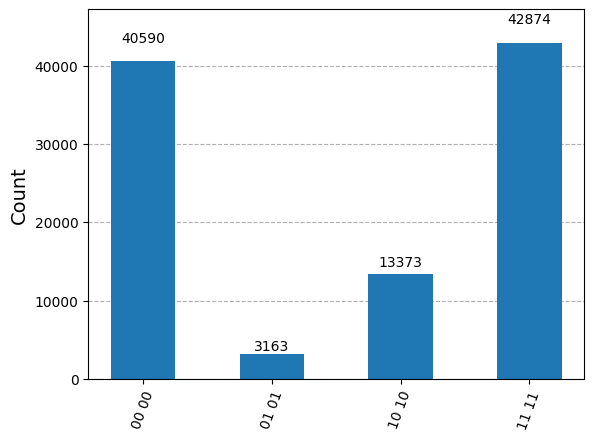

Execution time Qasm Simulator 0.00024890899658203125.


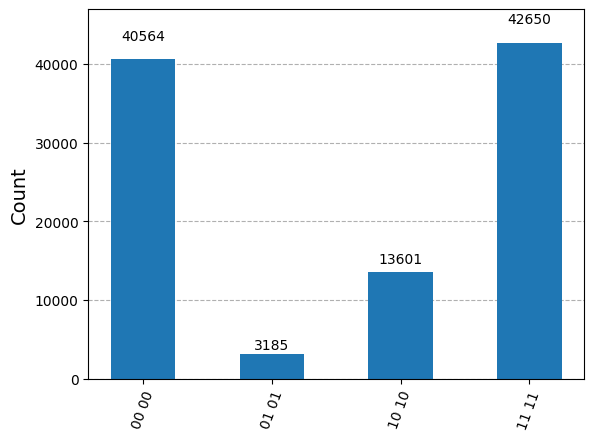

Execution time RunTime Sampler 0.004586935043334961.
Counts for the meas output register: {'10': 13485, '11': 42704, '00': 40578, '01': 3233}


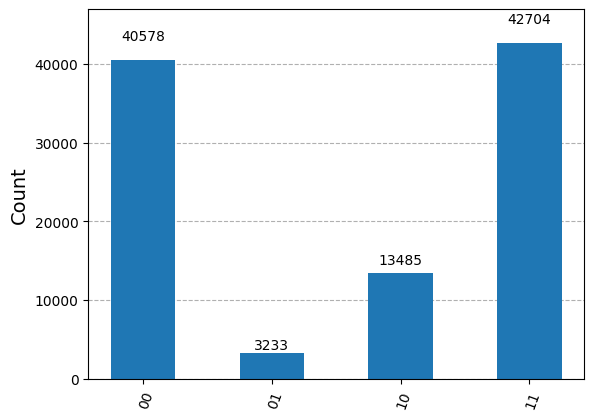

In [ ]:
############################################
# Test to check the limits of the Qiskit platform
# https://docs.quantum.ibm.com/run/primitives-examples
# https://docs.quantum.ibm.com/transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, Session
from qiskit.quantum_info import SparsePauliOp

# Define the number of qubits for the test
num_qubits = 2 # Maximum QasmSimulator 32: Quantum maximum, altough no access, 7 qubits
num_bits=num_qubits

# Create a quantum circuit with the desired number of qubits
qr=QuantumRegister(num_qubits,'q')
cr=ClassicalRegister(num_bits,'c')
qc=QuantumCircuit(qr,cr)

"""
# Apply Hadamard gate to all qubits for superposition
qc.h(qr)
# Apply a loop of CNOT gates to entangle the qubits
for i in range(num_qubits-1):
  qc.cx(qr[i], qr[i+1])
qc.cx(qr[num_qubits-1], qr[0])  # Close the loop to fully entangle the qubits
"""

NdepthLevels=4

qc = random_circuit(num_qubits, NdepthLevels, seed=0, conditional=True, measure=True).decompose(reps=1)

# Measure all qubits
qc.measure_all()

#display(print(qc))

# Simulate the quantum circuit
num_shots = 100000 # Maximum 1000000; Quantum maximum

# Execute the circuit on the AerSimulator
# Construct an ideal simulator
aersim = AerSimulator()
start = time.time()
job = aersim.run(qc, shots=num_shots)
end = time.time()
print(f'Execution time Aer Simulator {end - start}.')
result = job.result()
counts_Sim = result.get_counts(qc)
display(plot_histogram(counts_Sim))

# Execute the circuit on the QasmSimulator
backend = QasmSimulator(method='statevector')
qc_t = transpile(qc, backend)
start = time.time()
job = backend.run(qc_t,shots=num_shots)
end = time.time()
print(f'Execution time Qasm Simulator {end - start}.')
result=job.result()
counts_Sim = result.get_counts(qc)
display(plot_histogram(counts_Sim))

# For Qiskit RunTime Sampler and Estimator
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

backend = AerSimulator()#QasmSimulator(method='statevector')#service.least_busy(simulator=True, operational=True,min_num_qubits=num_qubits)

# Using Qiskit RunTime Sampler
sampler = Sampler(backend)
start = time.time()
job = sampler.run([isa_circuit],shots=num_shots)
end = time.time()
print(f'Execution time RunTime Sampler {end - start}.')
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
counts_RealSampler = pub_result.data.meas.get_counts()
print(f"Counts for the meas output register: {counts_RealSampler}")
#backend.configuration().to_dict() # Information on the limits of operation
display(plot_histogram(counts_RealSampler))

## Using Qiskit RunTime Estimator
#session=Session(service=service, backend=backend)
#ObservablesString="Z"*num_qubits
#observable = SparsePauliOp(ObservablesString) # Observable
#isa_observable = observable.apply_layout(isa_circuit.layout)
#estimator = Estimator(session=session)
#start = time.time()
#job = estimator.run([(isa_circuit,isa_observable)])
#end = time.time()
#print(f'Execution time RunTime Estimator {end - start}.')
#result = job.result()
##counts_RealEstimator = result#.get_counts(qc)
##display(plot_histogram(counts_RealEstimator))
#print(f"  > Expectation value: {result[0].data.evs}")